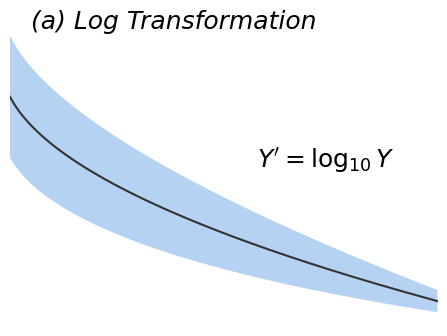

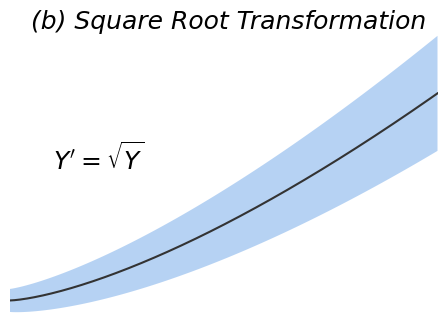

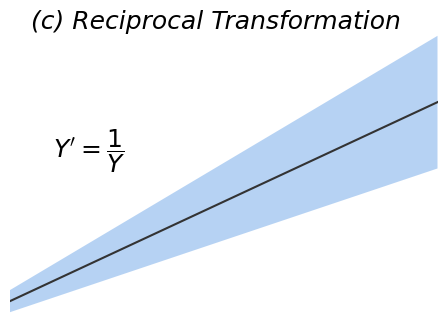

(<Figure size 450x320 with 1 Axes>, <Axes: >)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Union

ArrayLike = Union[np.ndarray, float]

def draw_pattern(
    x: np.ndarray,
    y: np.ndarray,
    width: ArrayLike,
    transform_label: str,
    title: str,
    filename: Union[str, Path],
    mean_color: str = "#333333",
    shade_color: str = "#4A90E2",
    show: bool = True,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Draw a regression-like mean curve with a symmetric variance band.

    Parameters
    ----------
    x : np.ndarray
        X-grid for the plot (e.g., np.linspace(0, 1, 300)).
    y : np.ndarray
        Mean curve values on the same grid as `x`.
    width : np.ndarray or float
        Half-width of the symmetric band around `y`. If scalar, it is broadcast.
    transform_label : str
        Right- or left-anchored annotation (e.g., r"$Y'=\sqrt{Y}$").
    title : str
        Small italicized title shown in the upper-left (e.g., "(a) Log Transformation").
    filename : str or Path
        Output filepath for saving the figure (PNG recommended).
    mean_color : str, default "#333333"
        Color for the mean line.
    shade_color : str, default "#4A90E2"
        Face color for the shaded band. Alpha is fixed at 0.4 to match originals.
    show : bool, default True
        Whether to call plt.show() after saving.

    Returns
    -------
    (fig, ax) : tuple
        Matplotlib Figure and Axes objects for further customization if desired.
    """
    # --- Figure & Axes --------------------------------------------------------
    # Use a compact canvas. We keep add_axes to preserve the original margins.
    fig = plt.figure(figsize=(4.5, 3.2))
    ax = fig.add_axes([0.025, 0.005, 0.95, 0.95])  # [left, bottom, width, height]

    # --- Prepare band edges ---------------------------------------------------
    w = np.asarray(width)  # allow scalar or array
    # Broadcast scalar half-width to match y if needed
    if w.ndim == 0:
        w = np.full_like(y, float(w))
    upper = y + w
    lower = y - w

    # --- Shaded band (variance pattern) --------------------------------------
    ax.fill_between(x, lower, upper, alpha=0.4, facecolor=shade_color)

    # --- Mean (best-fit) line -------------------------------------------------
    ax.plot(x, y, linewidth=1.5, color=mean_color)

    # --- Minimal styling (no ticks/spines) -----------------------------------
    ax.set_xlim(float(np.min(x)), float(np.max(x)))
    # 5% vertical padding, but at least 0.02 to avoid tight clipping
    pad = max((float(np.max(upper)) - float(np.min(lower))) * 0.05, 0.02)
    ax.set_ylim(float(np.min(lower)) - pad, float(np.max(upper)) + pad)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- Transformation label -------------------------------------------------
    # Keep the original left/right rule based on presence of "log"
    if "log" in transform_label:
        # Right edge, vertically centered
        ax.text(
            0.9, 0.5, transform_label, transform=ax.transAxes,
            va="bottom", ha="right", fontsize=18
        )
    else:
        # Left edge, vertically centered
        ax.text(
            0.1, 0.5, transform_label, transform=ax.transAxes,
            va="bottom", ha="left", fontsize=18
        )

    # --- Title ----------------------------------------------------------------
    ax.text(0.05, 0.98, title, transform=ax.transAxes, fontsize=18, style="italic")

    # --- Save & (optionally) show --------------------------------------------
    filename = Path(filename)
    filename.parent.mkdir(parents=True, exist_ok=True)  # ensure folder exists
    fig.savefig(filename, dpi=300, bbox_inches=None, pad_inches=0.1)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


# ------------------------ Example Usage (unchanged visuals) -------------------

# Shared x-grid
x = np.linspace(0, 1, 300)

# Panel 1: concave-down mean, decreasing variance -> Y' = log10 Y
y_log = 1.02 - 0.85 * np.sqrt(x + 0.02)
w_log = 0.18 * (1 - x) + 0.04
draw_pattern(
    x, y_log, w_log,
    r"$Y'=\log_{10} Y$",
    "(a) Log Transformation",
    "../images/fch10_YTransforms_log.png"
)

# Panel 2: convex-up mean, increasing variance -> Y' = sqrt(Y)
y_sqrt = 0.10 + 0.90 * (x ** 1.45)
w_sqrt = 0.05 + 0.20 * x
draw_pattern(
    x, y_sqrt, w_sqrt,
    r"$Y'=\sqrt{Y}$",
    "(b) Square Root Transformation",
    "../images/fch10_YTransforms_sqrt.png"
)

# Panel 3: linear mean with variance proportional to mean -> Y' = 1/Y
y_recip = 0.05 + 0.90 * x
w_recip = 0.05 + 0.25 * x
draw_pattern(
    x, y_recip, w_recip,
    r"$Y'=\dfrac{1}{Y}$",
    "(c) Reciprocal Transformation",
    "../images/fch10_YTransforms_reciprocal.png"
)

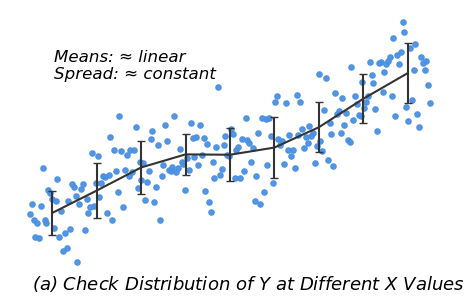

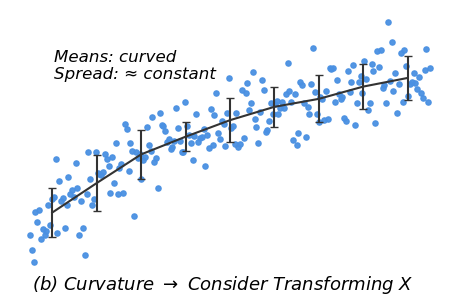

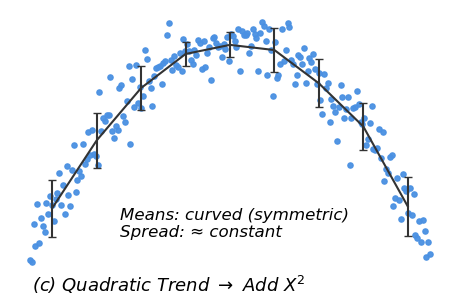

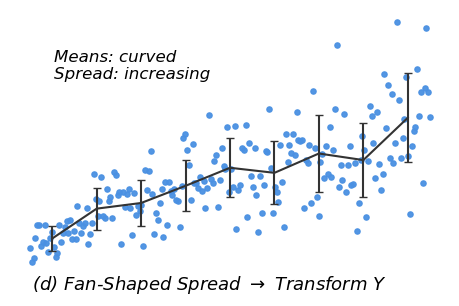

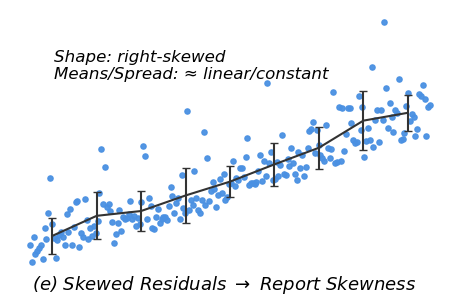

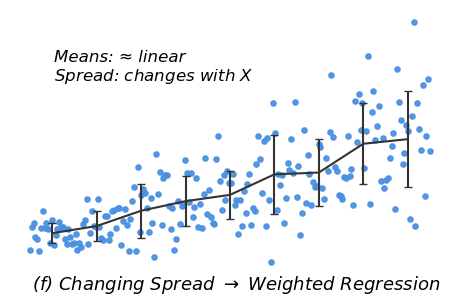

In [7]:
# Creates SIX separate PNGs with identical canvas size so Quarto rows align.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

# ---------- Style constants (edit here for consistent look) -----------------
POINT_COLOR   = "#4A90E2"   # scatter points
LINE_COLOR    = "#333333"   # line + SD error bars
POINT_ALPHA   = 0.95
LINE_WIDTH    = 1.5
CAP_SIZE      = 3           # size of error bar caps
FONT_SIZE_TOP = 13          # (a), (b), etc. title size
FONT_SIZE_BOT = 12          # bottom annotation text size
FIGSIZE       = (5, 3)      # keep identical across ALL panels
DPI           = 300
PAD_INCHES    = 0.1         # uniform margins in saved PNGs
NBINS         = 9           # number of vertical strips for means/SDs

# ---------- Helper: compute binned means and SDs ----------------------------
def bin_summary(x: np.ndarray, y: np.ndarray, nbins: int = NBINS) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute mean and standard deviation of y in vertical strips of x.

    Parameters
    ----------
    x, y : np.ndarray
        Data points for scatter plot.
    nbins : int, default NBINS
        Number of equally spaced bins along x.

    Returns
    -------
    centers : np.ndarray
        X-coordinate of bin centers.
    means : np.ndarray
        Mean y-value in each bin.
    sds : np.ndarray
        Standard deviation of y in each bin.
    """
    edges = np.linspace(x.min(), x.max(), nbins + 1)
    centers, means, sds = [], [], []

    for i in range(nbins):
        # Last bin includes the right edge
        mask = (x >= edges[i]) & (x < edges[i + 1]) if i < nbins - 1 else (x >= edges[i]) & (x <= edges[i + 1])
        if mask.any():
            centers.append(0.5 * (edges[i] + edges[i + 1]))
            means.append(y[mask].mean())
            sds.append(y[mask].std(ddof=1) if mask.sum() > 1 else 0.0)

    return np.array(centers), np.array(means), np.array(sds)

# ---------- Helper: create a single panel ------------------------------------
def plot_panel(
    x: np.ndarray,
    y: np.ndarray,
    outpath: str,
    note_bot: str,
    note_top: str
) -> None:
    """
    Create one panel: scatter + vertical-strip means and SD bars.
    Annotations are placed inside the axes so all panels have identical bounding boxes.

    Parameters
    ----------
    x, y : np.ndarray
        Data for the panel.
    outpath : str
        File path to save the PNG.
    note_bot : str
        Bottom or in-panel annotation describing means/spread.
    note_top : str
        Top-left annotation (e.g., "(a) ...").
    """
    fig = plt.figure(figsize=FIGSIZE)

    # Adjust horizontal position to visually align titles in Quarto layout
    if any(tag in note_top for tag in ["(a)", "(c)", "(e)"]):
        ax = fig.add_axes([0.11, 0.06, 0.88, 0.88])
    else:
        ax = fig.add_axes([0.01, 0.06, 0.88, 0.88])

    # Scatter points
    ax.scatter(x, y, s=14, color=POINT_COLOR, alpha=POINT_ALPHA)

    # Bin summaries (means + SDs as vertical error bars)
    centers, means, sds = bin_summary(x, y)
    if centers.size:
        ax.errorbar(
            centers, means, yerr=sds,
            fmt='-', lw=LINE_WIDTH, capsize=CAP_SIZE,
            color=LINE_COLOR, ecolor=LINE_COLOR, alpha=1.0
        )

    # Remove ticks and spines for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Top annotation
    ax.text(
        0.05, 0, note_top, transform=ax.transAxes,
        fontsize=FONT_SIZE_TOP, style='italic', va='top'
    )

    # Bottom/in-panel annotation
    if "(c)" in note_top:
        ax.text(
            0.25, 0.25, note_bot, transform=ax.transAxes,
            fontsize=FONT_SIZE_BOT, style='italic', va='top'
        )
    else:
        ax.text(
            0.10, 0.85, note_bot, transform=ax.transAxes,
            fontsize=FONT_SIZE_BOT, style='italic', va='top'
        )

    # Save (fixed canvas size; no tight layout)
    Path(outpath).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath, dpi=DPI, bbox_inches=None, pad_inches=PAD_INCHES)
    plt.show()
    plt.close(fig)

# ---------- Data & panel generation ------------------------------------------
rng = np.random.default_rng(7)
n = 220
x = np.linspace(0, 1, n)

# (a) Straight-line mean, ~equal SD
y_a = 0.55 * x + 0.12 + rng.normal(0, 0.10, n) + 0.05 * np.sin(6 * x + 0.6)
plot_panel(
    x, y_a, "../images/fch10_residuals_a.png",
    note_bot="Means: ≈ linear\nSpread: ≈ constant",
    note_top=r"(a) Check Distribution of $Y$ at Different $X$ Values"
)

# (b) Transform X: curved mean, ~equal SD
y_b = 0.85 * np.sqrt(x + 0.02) + rng.normal(0, 0.10, n)
plot_panel(
    x, y_b, "../images/fch10_residuals_b.png",
    note_bot="Means: curved\nSpread: ≈ constant",
    note_top=r"(b) Curvature $\rightarrow$ Consider Transforming $X$"
)

# (c) Include X^2: curved mean, ~equal SD (symmetric)
y_c = 1.00 - 4.2 * (x - 0.5) ** 2 + rng.normal(0, 0.095, n)
plot_panel(
    x, y_c, "../images/fch10_residuals_c.png",
    note_bot="Means: curved (symmetric)\nSpread: ≈ constant",
    note_top=r"(c) Quadratic Trend $\rightarrow$ Add $X^2$"
)

# (d) Transform Y: curved mean, increasing SD
sd_d = 0.06 + 0.22 * x
y_d = 0.85 * np.sqrt(x + 0.02) + rng.normal(0, 1.0, n) * sd_d
plot_panel(
    x, y_d, "../images/fch10_residuals_d.png",
    note_bot="Means: curved\nSpread: increasing",
    note_top=r"(d) Fan-Shaped Spread $\rightarrow$ Transform $Y$"
)

# (e) Skewed residuals: right-skew, ~equal SD
skew_noise = rng.gamma(shape=2.0, scale=0.06, size=n) - 0.12
y_e = 0.55 * x + 0.15 + skew_noise
plot_panel(
    x, y_e, "../images/fch10_residuals_e.png",
    note_bot="Shape: right-skewed\nMeans/Spread: ≈ linear/constant",
    note_top=r"(e) Skewed Residuals $\rightarrow$ Report Skewness"
)

# (f) Weighted regression: spread changes with X
sd_f = 0.05 + 0.22 * x
y_f = 0.60 * x + 0.10 + rng.normal(0, 1.0, n) * sd_f
plot_panel(
    x, y_f, "../images/fch10_residuals_f.png",
    note_bot="Means: ≈ linear\nSpread: changes with $X$",
    note_top=r"(f) Changing Spread $\rightarrow$ Weighted Regression"
)
